In [1]:
# Import numpy library for use in ...
import numpy as np

# Function info here ...
def import_fa(file_name, return_labels=False):
    print("Importing "+file_name)
    # List storage for file contents (sequences) and sequene labels
    sequences = []
    labels = []
    # Try to open the file as read only
    try:
        file = open(file_name, "r")
    # If the file would not open, print error message and exit
    except:
        print("\nError: Could not open file")
        print("File name given: "+file_name+"\n")
        raise SystemExit
    # Iterate over all the lines in the file
    for line in file.readlines():
        # If this character is at the start of the line, it is a sequence label
        if line[0] == ">":
            # If the argument 'return_labels' is True, append the label to a list
            if return_labels:
                labels.append(str(line)[1:-1])
            else:
                continue
        # Append the sequence to the list of sequences
        sequences.append(str(line)[:-1])
    print("    "+str(len(sequences))+" sequences")
    # If the argument 'return_labels' is True, return arrays of the sequences and labels
    if return_labels:
        return np.array(sequences), np.array(labels)
    # If False, only return an array of the sequences
    else:
        return np.array(sequences)

# Function info here ...
def raw_to_features(data,balance=False,resample=1.0):
    print("\nConverting to features:")
    n = len(data)
    # Find basic data stats for function use:
    #   the max length sequence in the data
    #   the number of classes
    #   count of each class
    max_seq_len = 0
    class_counts = [0]
    num_classes = -1
    # Iterate over all sequences
    for line in data:
        # Look out for a new class
        if "class" in line:
            class_counts.append(1)
            num_classes += 1
            continue
        # Update max sequence length
        if len(line) > max_seq_len:
            max_seq_len = len(line)
        # Update class counts
        class_counts[num_classes+1] += 1
    
    # Since this was -1 based, increment to convert to 0 based count
    num_classes += 1
    
    # Print stats found above
    print("  Num Classes:", num_classes)
    print("  Class Counts:")
    frmt = "{:>7}"*num_classes
    print(" "+frmt.format(*[i for i in range(num_classes)]))
    print("   ",end="")
    frmt = "{:>7}"*num_classes
    print(" "+frmt.format(*[class_counts[i] for i in range(1,num_classes+1)]))

    # Split data by class for resampling
    data_by_class = []
    for i in range(num_classes):
        data_by_class.append( data[class_counts[i]:class_counts[i+1]] )
    
    # Instantiate storage of features and labels
    X = []
    y = []
    
    # Init variables for resampling
    total_per_class = 0
    num_samples = n
    # If resampling:
    if resample != 1.0:
        # Calculate the size of the resampled dataset
        num_samples = int(n*resample)
        # If balanced classs coutns are required:
        if balance:
            # Calculate a balanced total number of instances per class
            total_per_class = int(num_samples/num_classes)
            # Pull instances
            for i in range(num_classes):
                for j in range(1,total_per_class+1):
                    X.append( data_by_class[i][j] )
            # Pull labels
            for i in range(num_classes):
                for j in range(total_per_class):
                    y.append(i)
        # If imbalanced class counts are acceptable
        else:
            # Calculate the total number of instances per class in the same ratio as class counts
            total_per_class = [int(num_samples*class_counts[i+1]/n) for i in range(num_classes)]
            # Pull instances
            for i in range(num_classes):
                for j in range(total_per_class[i]+1,total_per_class[i+1]+1):
                    X.append( data_by_class[i][j] )
            # Pull labels
            for i in range(num_classes):
                for j in range(total_per_class):
                    y.append(i)
        print("  Resampling:")
        print("    Total samples:",num_samples)
        print("    Total/class  :",total_per_class)
        print()
    # If not resampling
    # TODO:  Complete - could the above be used instead of conditional?
    else:
        total_per_class = int(n/num_classes)
    
    # Convert from strings to arrays and pad the sequences with zeros to 
    # the length of the maximum length sequence; this is the number of features
    for i in range(len(X)):
        # Instantiate new array of zeros
        new_instance = [0 for i in range(max_seq_len)]
        # Fill in sequence
        for j in range(len(X[i])):
            # Use the ord() function to convert to integer representation of characters
            new_instance[j] = ord(X[i][j])
        # Store new sequence in features store X
        X[i] = new_instance

    # Return features and labels
    return X,y

In [2]:
# For one-hot encoding
from tensorflow.keras.utils import to_categorical
# For the loss function and optimizer
import tensorflow.keras as keras
# For the model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU

2021-12-04 15:04:19.280356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 15:04:19.280375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Import the data and extract features
data = import_fa("data/pos_neg-unip.fa")
X, y = raw_to_features(data, balance=True, resample=0.1)

# Note: This next piece shows a temporary formatting of data to simulate more than one feature.
#       1. Cut off all values in the sequence after the 2000th index
#            (This is simply done for the sake of testing training, so that it doesn't take forever)
#       2. Reshape the dataset to be consistent with the requirements for the model
X = np.array(X)[:,:2000]
# Split the current only feature (feature inference to be added soon) into two
X = np.reshape(X, (-1,2,1000,1))
# Convert the labels to a one-hot encoding
y_one_hot = to_categorical(y)

# Split the data into train, test, and validation
from sklearn.model_selection import train_test_split
X, valid_X, y_one_hot, valid_y = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)
train_X, test_X, train_y, test_y = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)

# Number of data instances
n = len(train_X)
# Number of features
m = len(train_X[0])
# Length of sequence
o = len(train_X[0][0])

# Print some data info
print("Shape of X      :",np.shape(X))
print("Shape of train_X:",np.shape(train_X))
print("Shape of valid_X:", np.shape(valid_X))
print()
print('n (no. train samples):',n)
print('m (num features)     :',m)
print('o (length of seqs)   :',o)

Importing data/pos_neg-unip.fa
    30050 sequences

Converting to features:
  Num Classes: 2
  Class Counts:
       0      1
       3259  26791
  Resampling:
    Total samples: 3005
    Total/class  : 1502

Shape of X: (3004, 2, 1000, 1)
Shape of train_X: (1922, 2, 1000, 1)
n (number of samples): 1922
m (length of seqs)   : 2
o (num features)     : 1000


In [4]:
# Some model parameters
batch_size = 64
epochs = 20
num_classes = 2

# Instantiate the model
model = Sequential()

# Add layers
model.add(Conv2D(filters=32, kernel_size=(o,3),activation='linear',input_shape=(m,o,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2,padding='same'))

model.add(Conv2D(filters=64, kernel_size=(1,3),activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2,padding='same'))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
# For now, this gives errors about loading the dynamic library for GPU use
model.compile(
    loss=keras.losses.categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 1000, 32)       96032     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 1000, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 500, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 500, 64)        6144064   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 500, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 250, 64)       0         
 2D)                                                    

2021-12-04 15:04:23.451577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 15:04:23.451933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 15:04:23.451987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-04 15:04:23.452035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-04 15:04:23.452082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [5]:
# Train the model
history = model.fit(train_X, train_y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_y))

(1922, 2, 1000, 1)
(1922, 2)
Epoch 1/20
31/31 [==============================] - 248s 8s/step - loss: 0.6040 - accuracy: 0.6852 - val_loss: 0.6012 - val_accuracy: 0.6944
Epoch 2/20
31/31 [==============================] - 247s 8s/step - loss: 0.5729 - accuracy: 0.7107 - val_loss: 0.6431 - val_accuracy: 0.5634
Epoch 3/20
31/31 [==============================] - 259s 8s/step - loss: 0.5779 - accuracy: 0.6993 - val_loss: 0.5883 - val_accuracy: 0.7006
Epoch 4/20
31/31 [==============================] - 265s 9s/step - loss: 0.5564 - accuracy: 0.7123 - val_loss: 0.5635 - val_accuracy: 0.7027
Epoch 5/20
31/31 [==============================] - 256s 8s/step - loss: 0.5662 - accuracy: 0.7154 - val_loss: 0.5481 - val_accuracy: 0.7173
Epoch 6/20
31/31 [==============================] - 254s 8s/step - loss: 0.5083 - accuracy: 0.7492 - val_loss: 0.5739 - val_accuracy: 0.7069
Epoch 7/20
31/31 [==============================] - 252s 8s/step - loss: 0.4732 - accuracy: 0.7700 - val_loss: 0.5643 - val_a

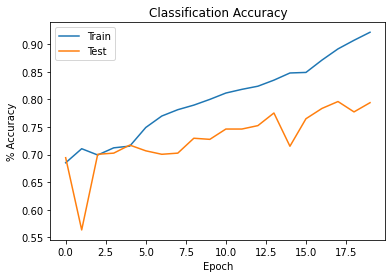

In [2]:
# Print some of the results
import matplotlib.pyplot as plt
# Loss over epochs
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('% Classification Accuracy')
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
print("Number of validation samples:",len(valid_X))
# Evaluate the model with the final evaluation testing set
results = model.evaluate(valid_X, valid_y)


601
19/19 [==============================] - 22s 1s/step - loss: 0.5664 - accuracy: 0.8303
